In [1]:
%matplotlib widget
import twixtools
from pygrappa import grappa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

from pylab import *
from matplotlib.widgets import LassoSelector
from mpl_interactions import image_segmenter

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

In [4]:
# parse the twix file
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00948_FID92103_t1_gradient_echo_tra_preheat.dat'))

twix_pre = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00948_FID92103_t1_gradient_echo_tra_preheat.dat'))
twix_post = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00952_FID92107_t1_gradient_echo_tra_postheat.dat'))

# twix is a list of measurements:
print('\nnumber of separate scans (multi-raid):', len(twix))

Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 16.4M/16.4M [00:00<00:00, 256MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 2.03M/2.03M [00:00<00:00, 266MB/s]

Software version: VD/VE (!?)



Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 16.4M/16.4M [00:00<00:00, 260MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 2.03M/2.03M [00:00<00:00, 577MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 16.4M/16.4M [00:00<00:00, 216MB/s]


Scan  1


100%|███████████████████████████████████████████████████████████████████████████████| 2.03M/2.03M [00:00<00:00, 383MB/s]


number of separate scans (multi-raid): 2


In [5]:
# access the protocol example: print the TR of the sequence
print('\nTE = %d ms\n'%(twix_pre[-1]['hdr']['Phoenix']['alTE'][0]/1000))


TE = 13 ms



In [7]:
# list the mdh flags and line counters for every 8th measurement data block (mdb)
for mdb in twix[-1]['mdb'][::8]:
    print('line: %3d; flags:'%(mdb.cLin), mdb.get_active_flags())

line:   0; flags: ['ONLINE', 'FIRSTSCANINSLICE']
line:   8; flags: ['ONLINE']
line:  16; flags: ['ONLINE']
line:  24; flags: ['ONLINE']
line:  32; flags: ['ONLINE']
line:  40; flags: ['ONLINE']
line:  48; flags: ['ONLINE']
line:  56; flags: ['ONLINE']


(8, 512)

k-space shape (64, 8, 512)
(64, 512) (64, 8, 512)


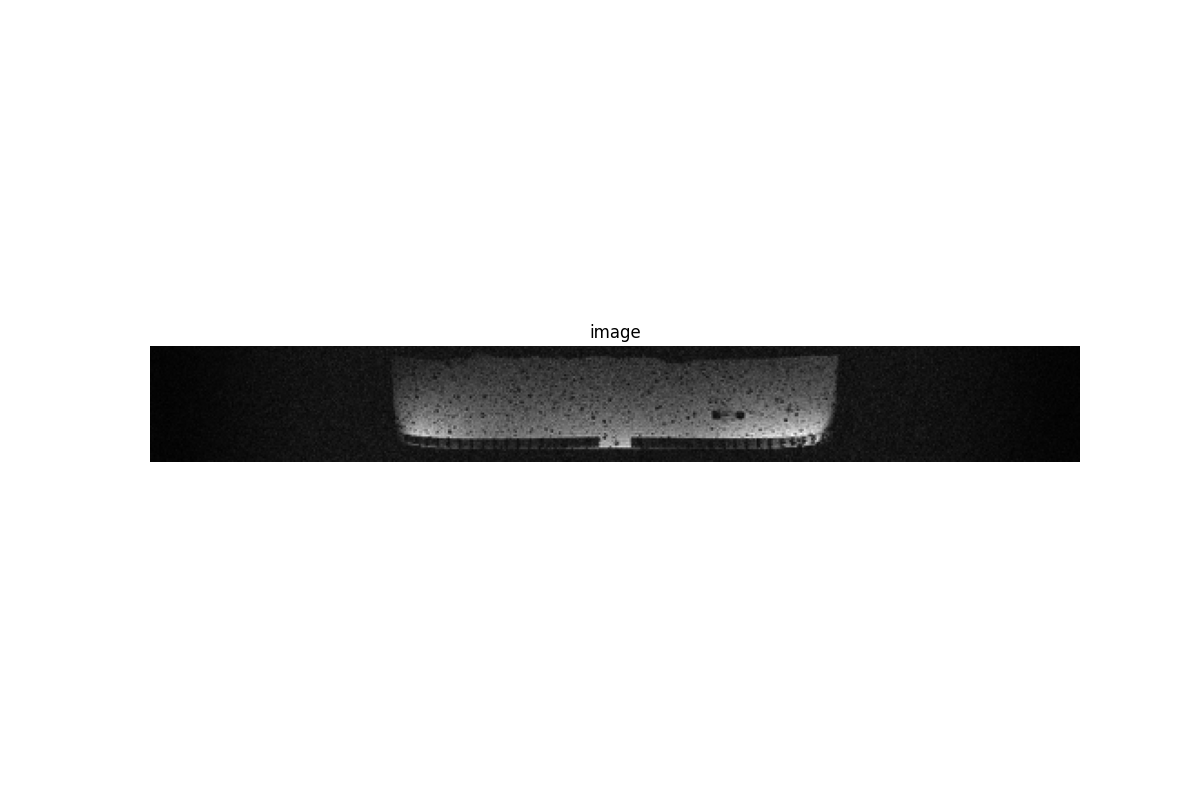

In [8]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix[-1]['mdb'] if mdb.is_image_scan()]

n_line = 1 + max([mdb.cLin for mdb in image_mdbs])

# assume that all data were acquired with same number of channels & columns:
n_channel, n_column = image_mdbs[0].data.shape
print(image_mdbs[0].data.shape)

kspace = np.zeros([n_line, n_channel, n_column], dtype=np.complex64)
for mdb in image_mdbs:
    kspace[mdb.cLin] = mdb.data

print('\nk-space shape', kspace.shape)

# reconstruct an image and show the result:
plt.figure(figsize=[12,8])
#plt.subplot(121)
# plt.title('k-space')
# plt.imshow(abs(kspace[:,0])**0.2, cmap='gray', origin='lower')
# plt.axis('off')


image = ifftnd(kspace, [0,-1])
image = rms_comb(image)
print(image.shape, kspace.shape)
#plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

dict_keys(['image', 'hdr', 'hdr_str'])
['Lin', 'Cha', 'Col']
(64, 8, 512)
Data shape at slice:  (64, 8, 512)


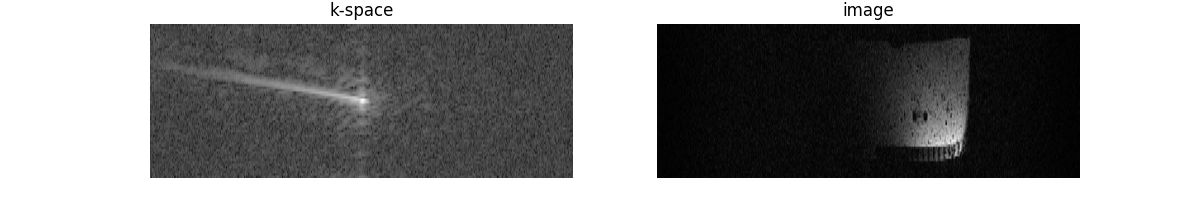

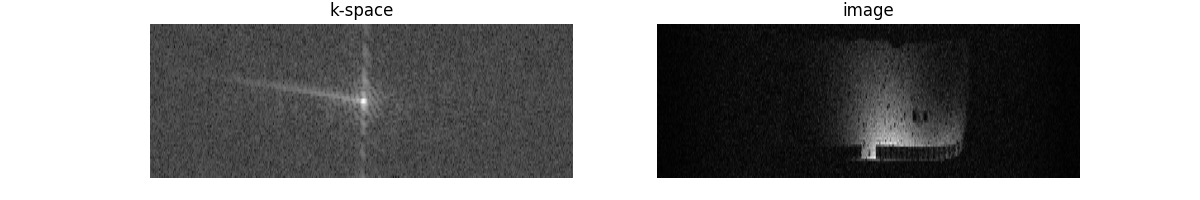

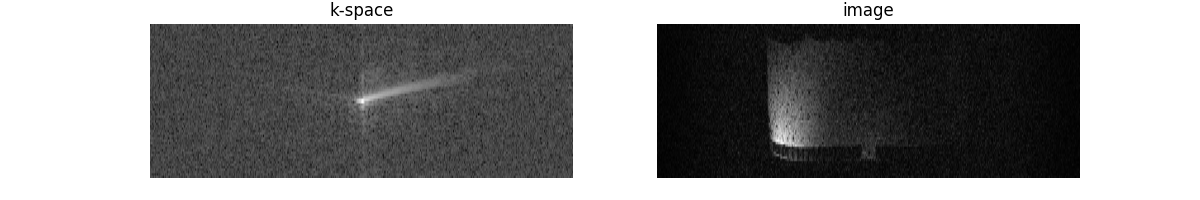

In [17]:
# map the twix data to twix_array objects
mapped = twixtools.map_twix(twix)
print(mapped[-1].keys())
im_data = mapped[-1]['image']

# make sure that we later squeeze the right dimensions:
print(im_data.non_singleton_dims)

# the twix_array object makes it easy to remove the 2x oversampling in read direction
im_data.flags['remove_os'] = False

# read the data (array-slicing is also supported)
data = im_data[:].squeeze()
print(data.shape)
print("Data shape at slice: ", data.shape)

for channel in range(4):

    plt.figure(figsize=[12,2])
    plt.subplot(121)
    plt.title('k-space')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    image = ifftnd(data[:,channel,:], [0, -1])
    #image = rms_comb(img_final)
    plt.subplot(122)
    plt.title('image')
    plt.imshow(abs(image), cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

plt.close()

In [14]:
# Now do it all again for pre/post and abbreviate code 

def get_grappa_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    cal_data = mapped[-1]['refscan']
    im_data.flags['remove_os'] = False

    data = im_data[:].squeeze()
    data = data[5,:,:,:]    
    data_cal = cal_data[:].squeeze()
    data_cal = data_cal[5,22:46,:,:]

    res = grappa(data, data_cal, coil_axis=1, silent=False)
    return res

def get_image_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    im_data.flags['remove_os'] = False
    data = im_data[:].squeeze()

    return data

res_pre = get_image_kspace(twix_pre)
res_post = get_image_kspace(twix_post)

image_pre = ifftnd(res_pre, [0,-1])
image_rms_pre = rms_comb(image_pre)
phase_img_pre = np.angle(image_pre)
phase_img_rms_pre = rms_comb(phase_img_pre)

image_post = ifftnd(res_post, [0,-1])
image_rms_post = rms_comb(image_post)
phase_img_post = np.angle(image_post)
phase_img_rms_post = rms_comb(phase_img_post)



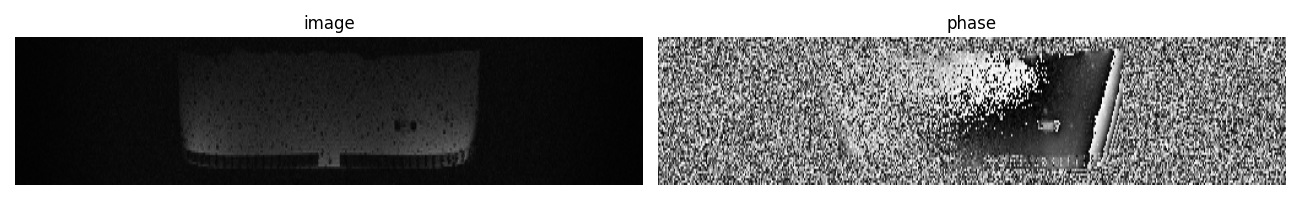

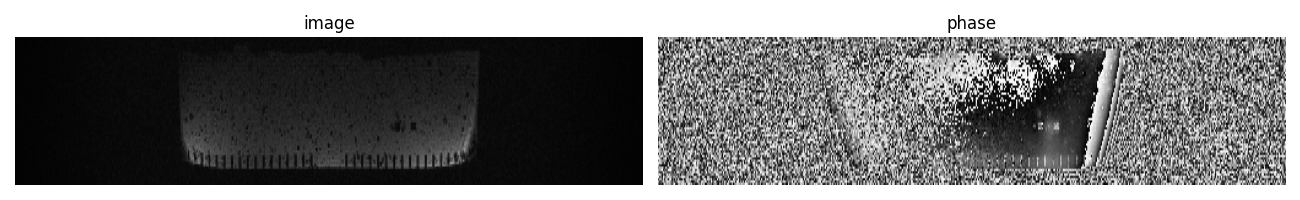

/tmp/ipykernel_1415/1127990811.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[13,2])


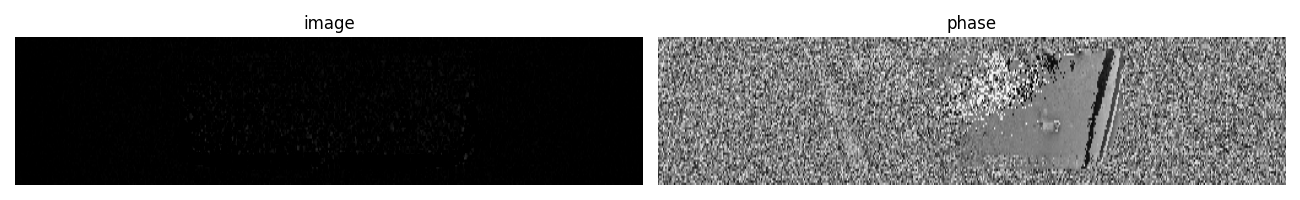

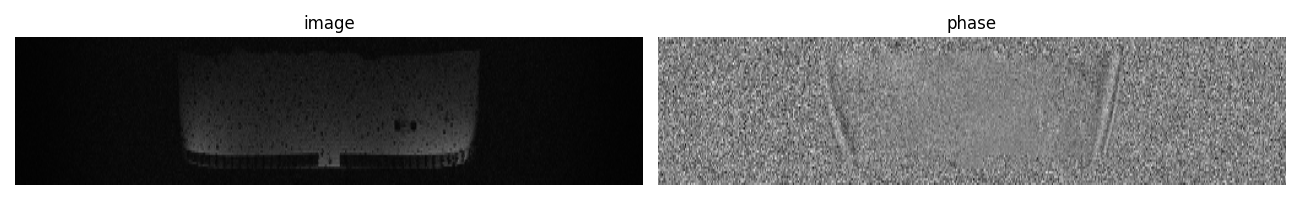

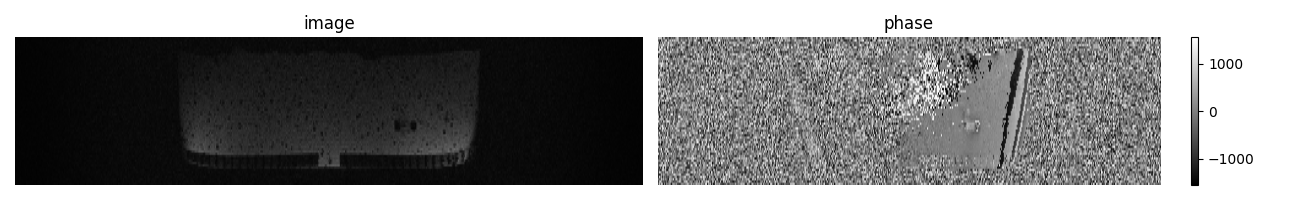

In [16]:
#Select ROI

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img_pre[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img_post[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) - abs(image_rms_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img_pre[:,0,:] - phase_img_post[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img_rms_pre - phase_img_rms_post, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()
    
# Calculate temperature map
alpha = 1e-8 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.5 #T
TE = 0.001 #s
temp_map = (phase_img_pre[:,0,:] - phase_img_post[:,0,:]) / (alpha*gyromagnetic_ratio*B0*TE)

plt.figure()
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('temp')
plt.imshow(temp_map, cmap='gray', origin='lower', aspect='auto')
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

plt.close()

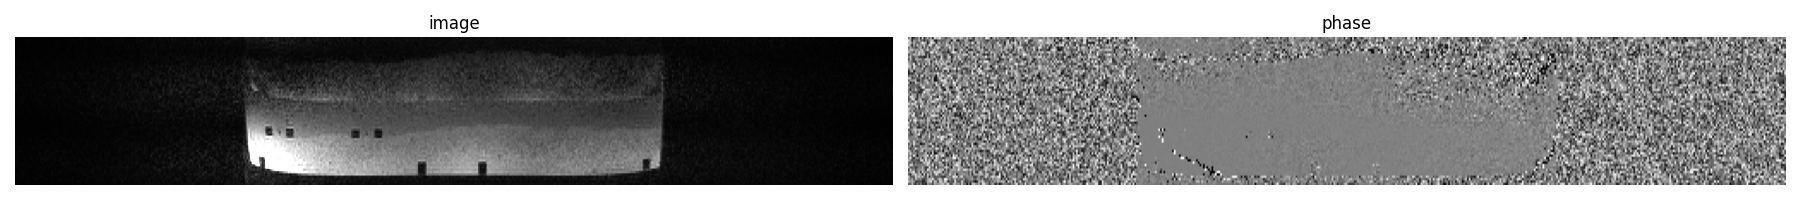

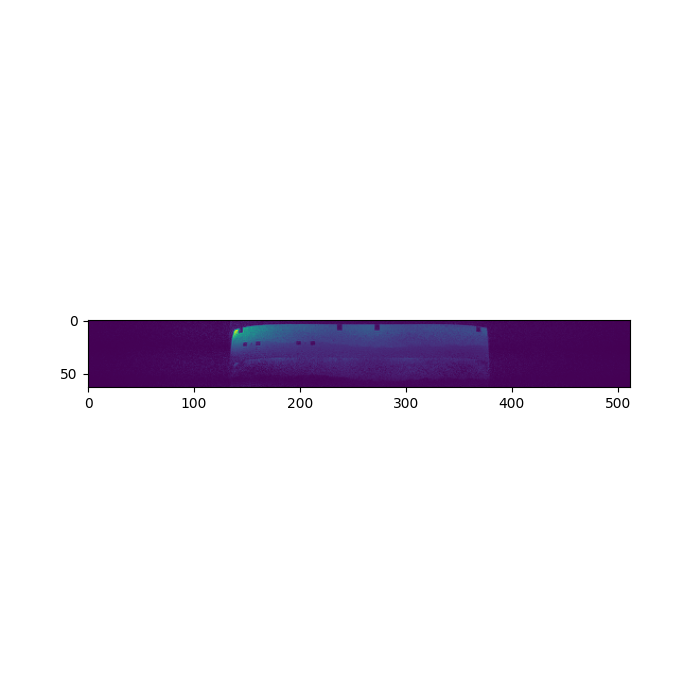

In [33]:
# Now get ROI specific information


def onselect(verts):
    print(verts)

%matplotlib ipympl

fig = plt.figure(figsize=[18,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

ax = plt.subplot(122)
plt.title('phase')
ax.imshow(phase_img_pre[:,0,:] - phase_img_post[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

segmenter = image_segmenter(abs(image_rms_post), mask_colors='red', mask_alpha=0.76, figsize=(7, 7))
display(segmenter)


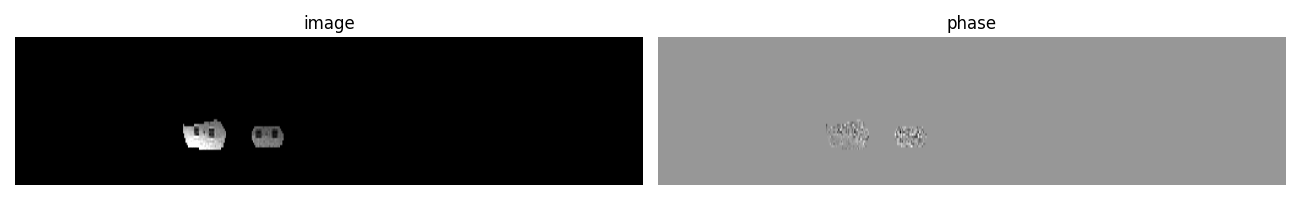

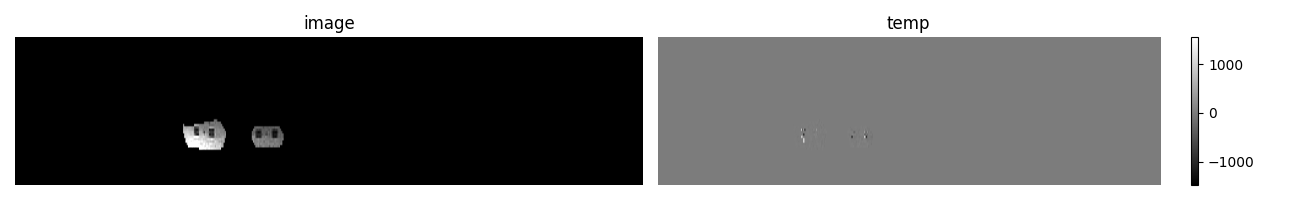

In [35]:
%matplotlib widget

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow((phase_img_rms_pre - phase_img_rms_post) * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('temp')
plt.imshow(temp_map * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.colorbar()
plt.show()

TypeError: Invalid shape (10, 4, 512) for image data

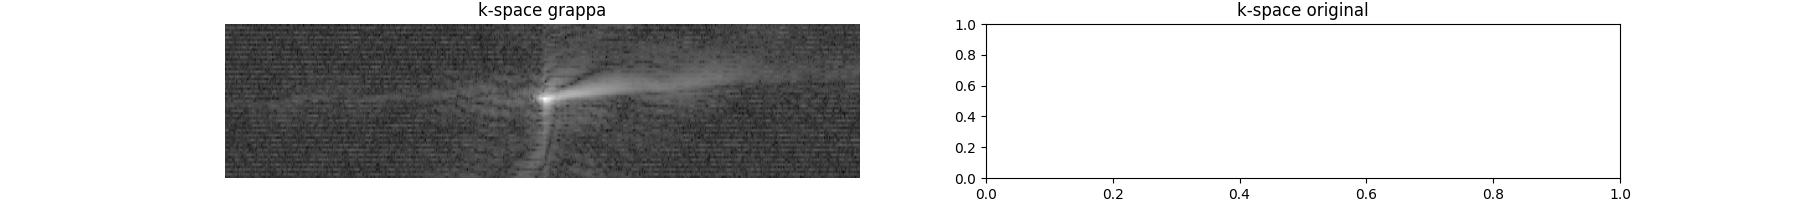

In [15]:
for channel in range(4):

    plt.figure(figsize=[18,2])
    plt.subplot(121)
    plt.title('k-space grappa')
    plt.imshow(abs(res[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    plt.subplot(122)
    plt.title('k-space original')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

plt.figure(figsize=[18,2])
image = ifftnd(res, [0,-1])
image_rms = rms_comb(image)
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

phase_img = np.angle(image)
phase_img_rms = rms_comb(phase_img)
plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
    
plt.tight_layout()

print(np.max(phase_img))

In [11]:
# Now make phase map for pre/post



In [12]:
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 7.03M/7.03M [00:00<00:00, 372MB/s]


In [13]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
print(data.shape)

(10, 63, 4, 512)
